# visualise segment predictions

In [236]:
import h5py
import numpy as np
from PIL import Image

import sys
sys.path.append('../')
from data import load_data

In [252]:
def combine_image(label_img, sat_img, alpha=96):
    """
    combine 2 images.
    """
    assert label_img.mode == "RGBA"
    label_arr = np.array(label_img)
    # black pixels
    black = label_arr[:,:, 0] + label_arr[:,:, 1] + label_arr[:,:, 2] == 0
    # set 0 alpha for all black pixels
    label_arr[black, 3] = 0
    # else set 'alpha'
    label_arr[np.logical_not(black), 3] = alpha
    label_img = Image.fromarray(label_arr, "RGBA")
    # combine
    combined_img = sat_img.copy()
    combined_img.paste(label_img, (0, 0), label_img)
    return combined_img

In [237]:
hdf5 = h5py.File("../predictions.hdf5")

In [238]:
predictions = hdf5.get("predictions")[()]
predictions.shape

(100, 65536, 7)

In [239]:
instance = 0
prediction = predictions[instance]
prediction.shape

(65536, 7)

In [240]:
class_prediction = prediction[:,2]
class_prediction.shape

(65536,)

## individual class heatmap

In [241]:
magenta_heat = [[0xff, 0xff, 0xff],
                [0xff, 0xf7, 0xf3],
                [0xfd, 0xe0, 0xdd],
                [0xfc, 0xc5, 0xc0],
                [0xfa, 0x9f, 0xb5],
                [0xf7, 0x68, 0xa1],
                [0xdd, 0x34, 0x97],
                [0xae, 0x01, 0x7e],
                [0x7a, 0x01, 0x77],
                [0x49, 0x00, 0x6a]]

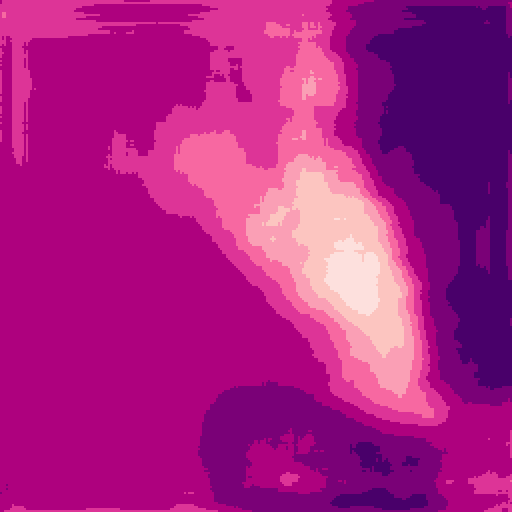

In [242]:
bins = 9 - np.floor(prediction[:, 4] * 10) # discretise
bins = bins.astype("uint8")
heat = np.array(magenta_heat)
img_arr = np.reshape(heat[bins], (256, 256, 3))
img_arr = img_arr.astype("uint8")
Image.fromarray(img_arr).resize((512, 512))

## segments

In [243]:
class_colours = np.array([[0xff, 0xff, 0xff],
                          [0xe4, 0x1a, 0x1c], 
                          [0x37, 0x7e, 0xb8],
                          [0x4d, 0xaf, 0x4a],
                          [0x98, 0x4e, 0xa3],
                          [0xff, 0x7f, 0x00],
                          [0xff, 0xff, 0x33]])

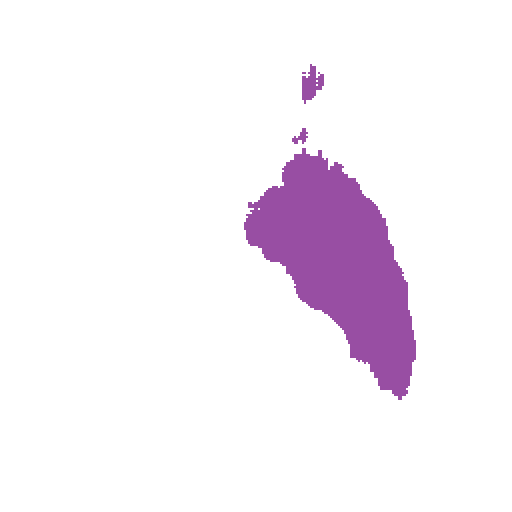

In [244]:
pixel_class = np.apply_along_axis(np.argmax, 1, prediction)
pixel_class = pixel_class.astype("uint8")
segment_colours = np.reshape(class_colours[pixel_class], (256, 256, 3))
segment_colours = segment_colours.astype("uint8")
Image.fromarray(segment_colours).resize((512, 512))

## overlay

In [245]:
# original test images and labels
images, labels = load_data(skynet_data="../../skynet-data/data", filtered="test-sample-filtered.txt", hdf5_data="../data/testing.hdf5")

Loading data from HDF5.


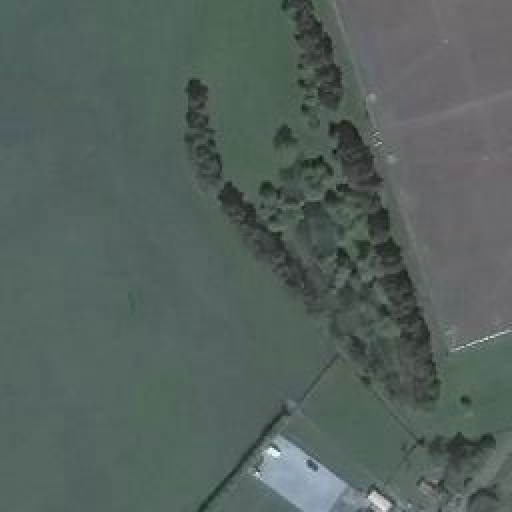

In [247]:
instance_arr = images[instance]
instance_arr = instance_arr*255 #denormalise
instance_arr = np.rollaxis(instance_arr, axis=0, start=3)
instance_arr = instance_arr.astype("uint8")
instance_label = labels[instance]
Image.fromarray(instance_arr).resize((512, 512))
#instance_arr.shape

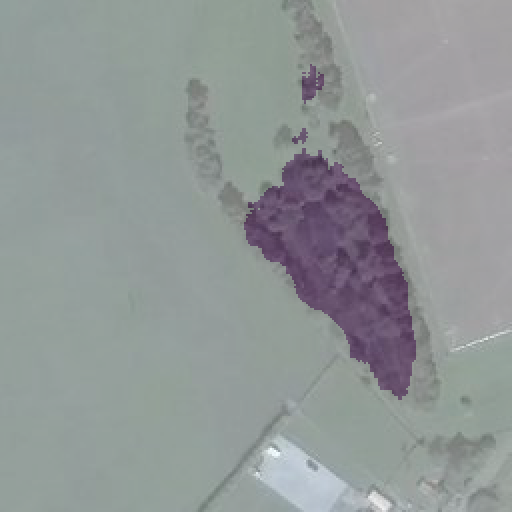

In [260]:
input_image = Image.fromarray(instance_arr.copy())
segment_image = Image.fromarray(segment_colours.copy())
segment_image = segment_image.convert("RGBA")
combined_image = combine_image(segment_image, input_image)
combined_image.resize((512, 512))